In [ ]:
from pyradiosky import SkyModel, utils
import numpy as np
from astropy.table import Table, setdiff, QTable
from astropy.utils.diff import report_diff_values
from astropy.io import fits
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import psutil
import erfa
sm = SkyModel()

ruby_catalog = sm.from_fhd_catalog("/Users/Kiana1/uwradcos/FHD/catalog_data/GLEAM_v2_plus_rlb2019.sav",
                                  expand_extended = True)
gleam_catalog = sm.from_gleam_catalog("/Users/Kiana1/uwradcos/gleam.vot", spectral_type = "subband", with_error = True)

In [ ]:
def log_linear_fit(freqs, fit_data, stokes_error, dec):
    # Fit logged data to linear polynomial
    #Compute combined error
    # calculate chi2 using raw data

    if (dec >= 18.5) or (dec <= -72):
        loc_error = fit_data * .03
    else:
        loc_error = fit_data * .02
    
    total_error = np.sqrt(loc_error**2 + stokes_error**2)
    first_weight = 1/total_error
    weight = np.log10(1 / total_error)
    
    #if np.isnan(np.sum(stokes_error)):
    #    print(fit_data, stokes_error)
    
    #Perform poly fit on logged data
    fit_data_log = np.log10(fit_data)
    freqs_log = np.log10(freqs)
    
    coeffs = poly.polyfit(freqs_log, fit_data_log, w = weight, deg=1)
    fit_log = poly.polyval(freqs_log, coeffs)
    
    fitted_data = 10**fit_log
    
    #compute chi2 value
    variance = total_error**2
    residual = fit_data - fitted_data
    chi2 = sum((residual**2) / variance)
    chi2_residual = chi2 / (len(freqs) - 2)
    
    return(coeffs, chi2_residual, fitted_data)

In [ ]:
# create dict of corresponding freqs and indices
freq_dict = dict(zip(range(0,20), list(gleam_catalog.freq_array.value)))

fit_parameters = np.array([[0,0]])
low_data_objs = np.array([[0,0,0]])
first_chi2 = []
second_chi2 = []
third_chi2 = []
final_chi2 = []
small_chi = []
errors = []
nan_sources = []
nan_data = []
nan_error = []

# Separate all rows that contain nans
for source in np.arange(gleam_catalog.Ncomponents):
    fit_data = gleam_catalog.stokes.value[0,:,source]
    dec = gleam_catalog.dec.value[source]
    freqs = gleam_catalog.freq_array.value
    stokes_error = gleam_catalog.stokes_error.value[0,:,source]
    
    # remove negative data by turning into nans before fitting
    fit_data[fit_data < 0] = np.nan
    
    # Subset to only data that is not nans before fitting
    if np.isnan(np.sum(gleam_catalog.stokes.value[0,:,source])):
        
        # finds position of non-nan values
        val_pos = np.argwhere(~np.isnan(gleam_catalog.stokes.value[0,:,source])).flatten()
        nan_pos = np.argwhere(np.isnan(gleam_catalog.stokes.value[0,:,source]))

        # makes list of freqs missing, subsets to only present freqs
        all_missing = [freq_dict.get(key) for key in nan_pos[:,0]]
        freqs = freqs[val_pos]
        
        # data and errors with no nans
        og_fit_data = fit_data
        og_stokes_error = stokes_error
        
        fit_data = gleam_catalog.stokes.value[0,val_pos, source]
        stokes_error = gleam_catalog.stokes_error.value[0,val_pos, source]
        
        if len(freqs) < 4:
            continue
            #low_data = np.array([[gleam_catalog.ra.value[source], gleam_catalog.dec.value[source], freqs, fit_data]])
            #low_data_objs = np.concatenate(low_data_objs, low_data)
    
    # Find sources that have error nans
    errors.append(np.sum(stokes_error))
    if np.isnan(np.sum(stokes_error)):
        nan_sources.append(source)
        nan_data.append(og_fit_data)
        nan_error.append(og_stokes_error)
    if np.isnan(np.sum(stokes_error)):
        continue
    
    coeffs, chi2_residual, fitted_data = log_linear_fit(freqs, fit_data, stokes_error, dec)
    first_chi2.append(chi2_residual)
    
    # If not good fit, run on bottom half of the freqs fitted and try again
    if chi2_residual >= 1.93:
        if len(freqs) >=8:
            half_freqs = freqs[:int(len(freqs) / 2)]
            fit_data_half = fit_data[:int(len(freqs) / 2)]
            error_half = stokes_error[:int(len(freqs) / 2)]
        
            coeffs, chi2_residual, fitted_data = log_linear_fit(half_freqs, fit_data_half, error_half, dec)
            second_chi2.append(chi2_residual)
            
            # If still not good, run on bottom quarter of freqs fitted
            if chi2_residual >= 1.93:
                qt_freqs = half_freqs[:int(len(half_freqs) / 2)]
                fit_data_qt = fit_data_half[:int(len(half_freqs) / 2)]
                error_qt = error_half[:int(len(half_freqs) / 2)]
        
                coeffs, chi2_residual, fitted_data = log_linear_fit(qt_freqs, fit_data_qt, error_qt, dec)
                third_chi2.append(chi2_residual)
            
        else:
            # run fit on bottom 4 frequencies if half the freqs is 4 or less
            bottom_freqs = freqs[:3]
            fit_data_bottom = fit_data[:3]
            error_bottom = stokes_error[:3]
            
            coeffs, chi2_residual, fitted_data = log_linear_fit(bottom_freqs, fit_data_bottom, error_bottom, dec)
            final_chi2.append(chi2_residual)
    
    else:
        small_chi.append(source)
    fit_parameters = np.concatenate((fit_parameters, np.array([coeffs])))
    
 
fit_parameters = np.delete(fit_parameters, [0,0], axis = 0)

In [ ]:
t = Table([np.array(nan_sources), np.array(nan_data), np.array(nan_error)], names = ('source', 'stokes_i_data', 'stokes_i_error'))
t.write('/Users/Kiana1/uwradcos/GleamPlusFullSpectrum/misc/nan_error_sources.fits', format='fits')

In [19]:
np.array(nan_sources)

array([ 19973,  19996,  20064,  20065,  20066,  20067,  20068,  20069,
       120492, 148414, 172500, 248971, 249112, 249113, 249114, 249115,
       249116, 249117, 262021, 266254, 266255, 266256, 266257, 266258,
       279394, 279395, 279396])

In [104]:
print("first chi2 < 1.93: ", len([x for x in first_chi2 if x < 1.93]))
print("first chi2 >= 1.93: ", len([x for x in first_chi2 if x >= 1.93]))
print("second chi2 < 1.93: ", len([x for x in second_chi2 if x < 1.93]))
print("second chi2 >= 1.93: ", len([x for x in second_chi2 if x >= 1.93]))
print("third chi2 < 1.93: ", len([x for x in third_chi2 if x < 1.93]))
print("third chi2 >= 1.93: ", len([x for x in third_chi2 if x >= 1.93]))
print("final chi2 < 1.93: ", len([x for x in final_chi2 if x < 1.93]))
print("final chi2 >= 1.93: ", len([x for x in final_chi2 if x >= 1.93]))

first chi2 < 1.93:  283565
first chi2 >= 1.93:  23489
second chi2 < 1.93:  13732
second chi2 >= 1.93:  9754
third chi2 < 1.93:  4819
third chi2 >= 1.93:  4935
final chi2 < 1.93:  2
final chi2 >= 1.93:  1


Text(0.5, 1.0, 'Residual Chi2 <20, all freqs')

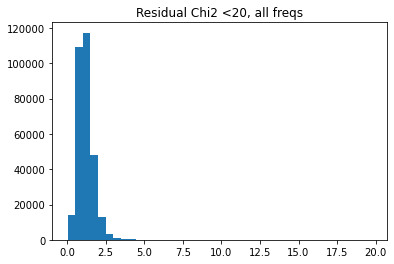

In [79]:
# Distribution of chi2 values after fitting on all freqs
first_chi2[:] = [x for x in first_chi2 if x <= 20]
plt.hist(first_chi2, bins = 40)
plt.title("Residual Chi2 <20, all freqs")

Text(0.5, 1.0, 'Residual Chi2 <20, bottom half freqs')

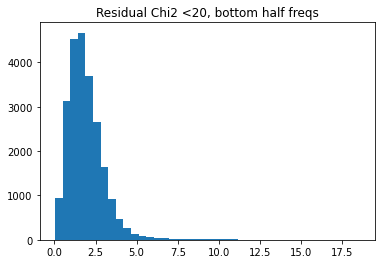

In [81]:
# Distribution of chi2 values after fitting on bottom half of freqs
second_chi2[:] = [x for x in second_chi2 if x <= 20]
plt.hist(second_chi2, bins = 40)
plt.title("Residual Chi2 <20, bottom half freqs")

Text(0.5, 1.0, 'Residual Chi2, bottom quarter freqs')

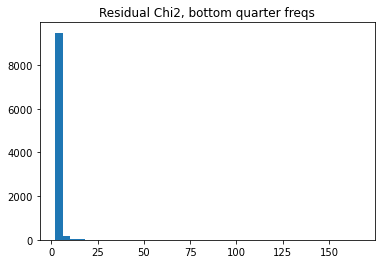

In [96]:
# Distribution of chi2 values after fitting on bottom half of freqs
third_chi2[:] = [x for x in third_chi2]# if x <= 20]
plt.hist(third_chi2, bins = 40)
plt.title("Residual Chi2, bottom quarter freqs")

Text(0.5, 1.0, 'Residual Chi2, bottom 4 freqs')

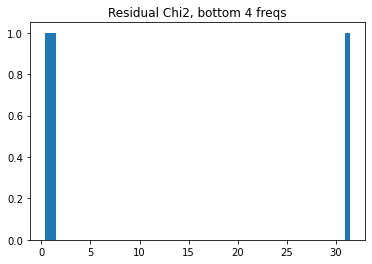

In [84]:
# Distribution of chi2 values after fitting on bottom 4 freqs
final_chi2[:] = [x for x in final_chi2] # if x <= 5000]
plt.hist(final_chi2, bins = 0)
plt.title("Residual Chi2, bottom 4 freqs")

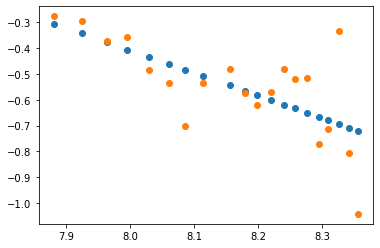

In [415]:
plt.scatter(freqs_log, fit)
plt.scatter(freqs_log, fit_data_log)

(10,)
(10,)
(10,)


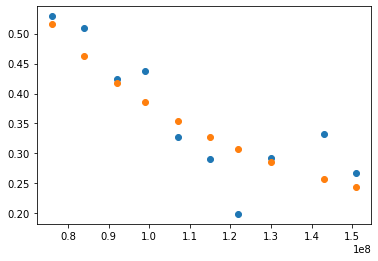

In [604]:
plt.scatter(half_freqs, fit_data_half)
plt.scatter(half_freqs, fitted_data)

In [394]:
print(p[0]*fit_data)
print(fit_data)

[0.24092082 0.25528853 0.32508603 0.31211276 0.4234317  0.46659117
 0.61092288 0.46488217 0.41741449 0.4993785  0.54080973 0.4977393
 0.41869153 0.45128907 0.44994083 0.67267761 0.61968604 0.28999502
 0.70236065 0.90777771]
[-0.27654679 -0.29303911 -0.37315787 -0.35826618 -0.48604632 -0.53558796
 -0.70126261 -0.53362624 -0.47913933 -0.57322369 -0.62078153 -0.5713421
 -0.4806052  -0.51802307 -0.51647546 -0.77214927 -0.71132161 -0.3328778
 -0.80622167 -1.04201461]


Plotting Data

In [ ]:
#plot all ruby's catalog points
fig = go.Figure(data=go.Scatter(
    x = ruby.ra,
    y = ruby.dec,
    mode='markers',
    marker=dict(
        size=2,
        color=ruby.stokes_i, #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    )
))

fig.write_html('./plots/ruby_data.html')

#plot all ruby's catalog points that are NOT in GLEAM
fig = go.Figure(data=go.Scatter(
    x = ruby_not_in_gleam.ra,
    y = ruby_not_in_gleam.dec,
    mode='markers',
    marker=dict(
        size=2,
        color=ruby_not_in_gleam.stokes_i, #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    )
))

fig.write_html('./plots/only_ruby_data.html')

In [ ]:
#plot all gleam points
fig = go.Figure(data=go.Scatter(
    x = gleam.ra,
    y = gleam.dec,
    mode='markers',
    marker=dict(
        size=2,
        color=gleam_log, #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    )
))

fig.write_html('./plots/gleam_data.html')

In [ ]:
gleam = pd.DataFrame(data = {'ra': gleam_catalog.ra, 'dec': gleam_catalog.dec, 'stokes_i': gleam_stokes[0,13,:]})
ruby = pd.DataFrame(data = {'ra': ruby_catalog.ra, 'dec': ruby_catalog.dec, 'stokes_i': ruby_stokes[0,0,:]})

In [ ]:
stokes_I = gleam_stokes[0,13,:]
plt.scatter(gleam_catalog.ra, gleam_catalog.dec, .1, marker = ".", c=gleam_stokes[0, 13,:], norm=co.LogNorm())
#plt.scatter(ruby_catalog.ra, ruby_catalog.dec, .1, marker = ".", c=ruby_stokes[0,:,:])